In [15]:
import csv
import json

import matplotlib.pyplot as plt

import re
import seaborn as sns
import snscrape
import tweepy
import pandas as pd

<h2>Tweet Scraping for Penny Stock Moguls

The first step is to use <b>snscrape</b> and <b>Tweepy</b> to scrape all tweets from certain users that have been identified to be "Penny Stock Moguls". The framework was laid by first scraping tweets from the user @buysellshort.

### Create full list of URL's for BSS tweets

In [53]:
# groundwork for function - add in more usernames
# twitter_users = []

!snscrape twitter-user buysellshort > buysellshort.json

# convert JSON file that snscrape outputs to a CSV with full tweet details
def json_to_csv(file_name):
    """
    Takes in json file and writes it into a csv file of the same name.
    """
    file_name = str(file_name)
    table = []
    with open((file_name+'.json'), 'r', encoding="utf8") as f:
        for line in f:
            table.append(line)
    pd.DataFrame(table).to_csv(file_name+'.csv')
    
    return table

bss = json_to_csv('buysellshort')

In [4]:
# call up csv file

bss_df = pd.read_csv('buysellshort.csv')

In [7]:
# Add id column

af = lambda x: x["0"].split("/")[-1][:-1]
bss_df['id'] = bss_df.apply(af, axis=1)
bss_df.head()

,Unnamed: 0,0,id
0,0,https://twitter.com/buysellshort/status/132478...,1324789312584511488
1,1,https://twitter.com/buysellshort/status/132478...,1324787585361694720
2,2,https://twitter.com/buysellshort/status/132478...,1324783974275674113
3,3,https://twitter.com/buysellshort/status/132478...,1324783814082658304
4,4,https://twitter.com/buysellshort/status/132478...,1324783761247019013


In [8]:
# Drop unnecessary column and rename existing

bss_df = bss_df.drop(columns=['Unnamed: 0'])
bss_df.columns = ['tweet_url', 'id']

### Use API to get Tweet text and meta data

In [101]:
# Input Tweepy API and Access tokens

consumer_key = 'SbKSnTmMAarrMpYxjYCXUFJnf'
consumer_secret = 'LKIUvARO8EGTJ7LsJSSs1BG1pFZvNXOHYw1ExeqXHAof0u5GlG'
access_token = '1324933189824110593-hhqL3P8GrzgRCWoIbbdlPSMbHrhTi6'
access_token_secret = '2l0FA1jC8GjjEawIk04JrL1qgF5ItzNb9xvCJfHpZHMcl'

# Set Authorization and API permissions

auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Test for functional authorization

try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

In [90]:
# Test with small sample

sample = api.statuses_lookup(ids[1:100],tweet_mode='extended')

In [92]:
# Check sample

for status in sample: 
    print("The status " + str(status.id) + " is posted by " + status.user.screen_name +'\n') 
    print("This status says : \n\n" + status.full_text.replace('\n',''), end = "\n\n") 

The status 1323289300054679552 is posted by buysellshort

This status says : 

$DGLY zooooming $EMAN $1.30 launch this was $1.55 on the last DLGY run a few days ago

The status 1323276975679500288 is posted by buysellshort

This status says : 

$SUNW https://t.co/3yHDCJ3QXw

The status 1323639810569822208 is posted by buysellshort

This status says : 

@Ponte93244889 bookmarked to retweet the big results down the road

The status 1323274929400283137 is posted by buysellshort

This status says : 

$INUV advertising revenue rebound play on the big gains in $GOOG rev INUV ad revenue had also dropped w/Google so the Google report a great sign for this bottomed out play  . INUV  news today stating they are  moving their earnings report UP one day to Monday. News coming?.

The status 1324724205057761282 is posted by buysellshort

This status says : 

$WTER https://t.co/JVc3CjcG3h

The status 1322946106544697345 is posted by buysellshort

This status says : 

CASH and popcorn for the coming d

The sample looks good! Let's move on to a larger corpus...

In [42]:
# create list of BuySellShort tweet id's

ids = bss_df['id'].tolist()

# set the amount of individual tweets, to be divided into chunk to avoid being shut out by the API
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

In [142]:
# define function to fetch tweets, which also exists in project_functions.py

def fetch_tw(ids,filename):
    # create list of statuses using API, and empty pandas df to store tweets 
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    
    # for loop to access statuses, username, and timestamp - then update empty_data table
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     # replace line breaks, commas (for csv), 
                     # and make cashtags into hashtags (removed in external function)
                     "tweet":status.full_text.replace('\n','').replace(',','').replace('$','#'),
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
            
    # write dataframe to csv
    empty_data.to_csv("{filename}.csv".format(filename=filename), mode="a")

In [150]:
# loop through 50-Tweet cycle to bypass API error

for i in range(chunks-1):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch,'bss_tweets_1')

In [149]:
# Directly scrape tweets in batches of 50 Tweets

with open("bss_tweets.csv", 'rb') as f:
    reader = csv.reader(f)
    linenumber = 1
    try:
        for row in reader:
            linenumber += 1
    except Exception as e:
        print (("Error line %d: %s %s" % (linenumber, str(type(e)), e)))

Error line 1: <class '_csv.Error'> iterator should return strings, not bytes (did you open the file in text mode?)


In [159]:
# Confirm that the table was scraped properly

bss_tweets = pd.read_csv('bss_tweets.csv',sep=None)
bss_tweets

,Unnamed: 0,date,screen_name,tweet,tweet_id
0,0,2020-11-06 14:43:57,buysellshort,#WTER https://t.co/JVc3CjcG3h,1.3247242050577613e+18
1,1,2020-11-05 15:18:07,buysellshort,#WWR #5+ target I gave is actually a CONSERVAT...,1.324370415511171e+18
2,2,2020-11-05 16:46:02,buysellshort,#SXTC china pennies on fire today 50% upside o...,1.324392541966332e+18
3,3,2020-11-05 20:29:30,buysellshort,#SNDL add this vol i see those late day chaser...,1.324448777105666e+18
4,4,2020-11-06 15:41:04,buysellshort,#SNDL https://t.co/BJ9oqqY3EO,1.3247385796045414e+18
...,...,...,...,...,...
36567,44,2008-12-31 20:15:47,buysellshort,#BKHM another with huge upside potential,1088674537.0
36568,45,2008-12-29 17:44:48,buysellshort,#ETFC will be one to watch once this tax selli...,1084295910.0
36569,46,2008-12-29 17:20:25,buysellshort,#EGHT has gained 50% on average from december ...,1084254857.0
36570,47,2008-12-30 18:33:21,buysellshort,As I said yesterday #USO hasn't been able to r...,1086350371.0


## Extending to Multiple Users

Now, the scraping process for @buysellshort can be extended to five other users - <b>alexcutler247, AlexDelarge6553, simbatrading, StockLizardKing,</b> and <b>timothysykes.</b>
<br><br>
These users exemplify a few different types of Penny Stock Moguls - some storied "financial educators", and others people who just started trading in April 2020. No matter their origin, they have all gained a following of users that listen to and act on their financial reccomendations. 

In [182]:
# Use external function to create a table of Tweets (see project_functions for code)

from project_functions import tweet_table

In [679]:
'''

private users (unscrapable) - 'MrZackMorris', 'StanTheTradingMan', 'yatesinvesting'

^ in the future, these users would be great to incorporate in this study - for now, it is impossible to scrape
their Tweets due to their chosen security level.

''' 

# define list of users whose Tweets will be scraped
usernames = ['buysellshort','AlexDelarge6553','timothysykes','StockLizardKing', 
             'simbatrading','alexcutler247']

# call tweet_table function to create a table of Tweets for these six users
for username in usernames[1:7]:
    tweet_table(username)

In [4]:
# read in each individual Tweet

buysellshort_tweets = pd.read_csv('data/buysellshort_tweets.csv', sep=None)
AlexDelarge6553_tweets = pd.read_csv('data/AlexDelarge6553_tweets.csv', sep=None)
timothysykes_tweets = pd.read_csv('data/timothysykes_tweets.csv', sep=None)
StockLizardKing_tweets = pd.read_csv('data/StockLizardKing_tweets.csv', sep=None)
SimbaTrading_tweets = pd.read_csv('data/SimbaTrading_tweets.csv', sep=None)
alexcutler247_tweets = pd.read_csv('data/alexcutler247_tweets.csv', sep=None)

<ipython-input-4-437cdd66e3b6>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  buysellshort_tweets = pd.read_csv('data/buysellshort_tweets.csv', sep=None)
<ipython-input-4-437cdd66e3b6>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  AlexDelarge6553_tweets = pd.read_csv('data/AlexDelarge6553_tweets.csv', sep=None)
<ipython-input-4-437cdd66e3b6>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  timothysykes_tweets = pd.read_csv('data/timothysykes_tweets.csv', sep=None)
<ipython-input-4-437cdd66e3b6>:4: ParserWarning: Falling back to the 'python' engine because the 

In [4]:
# Set length variable to find total amount of Tweets

length = len(buysellshort_tweets) + len(AlexDelarge6553_tweets) + len(timothysykes_tweets) + len(StockLizardKing_tweets) + len(SimbaTrading_tweets) + len(alexcutler247_tweets)
print('There are ', length, ' total collected Tweets.')

There are  234450  total collected Tweets.


In [6]:
# merge all individual tweet tables

total_tweets = pd.concat([buysellshort_tweets,AlexDelarge6553_tweets,timothysykes_tweets,StockLizardKing_tweets, 
                          SimbaTrading_tweets,alexcutler247_tweets])
total_tweets = total_tweets.reset_index(drop=True)

In [7]:
# rename columns, drop values, and reset index

total_tweets.columns = ['original_index', 'date', 'screen_name', 'tweet', 'tweet_id']
total_tweets = total_tweets.dropna()
total_tweets = total_tweets.reset_index(drop=True)

In [8]:
# create cashtag * column to capture all cashtags (and some unfiltered hashtags)

total_tweets['cashtag'] = total_tweets.tweet.apply(lambda x: re.findall(r"[$][a-zA-Z]+", x))
total_tweets['hashtag'] = total_tweets.tweet.apply(lambda x: re.findall(r"[#][a-zA-Z]+", x))

''' 
A note about cashtags - they are used on Twitter in the same way that hashtags are used - for example, Tesla,
which trades under the stock symbol TSLA, is usually "cashtagged" as $TSLA on Twitter and other social media
sites. This allows easier and more directed tracking of traded companies. 
'''

In [9]:
# Set df to tweets that have a cashtag (some from these users do not)

total_tweets = total_tweets[total_tweets['cashtag'].apply(lambda x: len(x)) > 0]
total_tweets = total_tweets.reset_index(drop=True)

In [10]:
# extracts first (PRIMARY) cashtag from list of cashtags in tweet

primary_cashtag_list = []

for i, tag in enumerate(total_tweets.cashtag):
        primary_cashtag_list.append(tag[0])
        
total_tweets['primary_cashtag'] = primary_cashtag_list

In [11]:
# capitalize all cashtags

total_tweets['primary_cashtag'] = total_tweets['primary_cashtag'].apply(lambda x: x.upper())

In [ ]:
# set all date cells to datetime

total_tweets.date = total_tweets.date.apply(pd.to_datetime)

In [ ]:
# add column for year

total_tweets['year'] = total_tweets.date.apply(lambda x:x.year)
total_tweets['month'] = total_tweets.date.apply(lambda x:x.month)

In [12]:
# view 25 most tweeted stocks 

total_tweets.primary_cashtag.value_counts().head(25)

$FB       17031
$SPOM      4847
$TWTR      1433
$VRUS       853
$TLSS       623
$AAPL       563
$CLSH       488
$PASO       471
$GENE       432
$STUDY      412
$IDEX       385
$GRNF       366
$HDII       338
$SPAQ       333
$COOL       315
$SBES       302
$ENZC       300
$GNUS       296
$TSLA       292
$MVIS       290
$DSGT       288
$MCZ        287
$DIA        268
$DCTH       261
$CRGED      259
Name: primary_cashtag, dtype: int64

<b>NOTE: See "Text preprocessing" Notebook for details on finding tokens and Polarity features

In [1]:
total_tweets = pd.read_csv('data/total_tweets.csv')

##  Incorporating AlphaVantage data

In [2]:
from alpha_vantage.timeseries import TimeSeries

# establish API connection

API = 'BSYXKOPDGVPJQWNO'
ts = TimeSeries(API)

In [4]:
# remove cash symbol from cashtag 

total_tweets['primary_cashtag'] = total_tweets.primary_cashtag.str.replace('$','')

In [5]:
# Determine what cashtags have been tweeted about by all or most of the users

tweets_by_tag = total_tweets.groupby(['primary_cashtag', 'screen_name']).count().reset_index()
tweets_by_tag.primary_cashtag.value_counts()

TSLA    6
IBIO    6
AAPL    6
DGLY    5
CTRM    5
       ..
SNDE    1
OGXI    1
SVBL    1
SIGA    1
CSSE    1
Name: primary_cashtag, Length: 3993, dtype: int64

In [ ]:
# This function acquires the percentage change throughout the day 
# Can fetch data for any stock in the past 100 days
# DATE FORMAT - '2020-10-20'

data, meta = ts.get_daily(symbol='SPOM')

def get_percentage_change(stock, date):
    open_value = float(data[date]['1. open'])
    close_value = float(data[date]['4. close'])
    difference = close_value - open_value
    percentage = round(difference/open_value,4)
    
    return percentage

In [7]:
# Use AlphaVantage to scrape change in stock percentage between open and close for each cashtag date

percentage_change_list = []
failed_dates = []

for i, cashtag in enumerate(alex_spom_tweets.primary_cashtag):
    try: 
        print(f'{i}, still scraping...')
        date = alex_spom_tweets.date[i][:10]
        change = get_percentage_change(cashtag,date)
        percentage_change_list.append(change)
        time.sleep(1)
    except:
        failed_dates.append(date)


0, still scraping...
1, still scraping...
2, still scraping...
3, still scraping...
4, still scraping...
5, still scraping...
6, still scraping...
7, still scraping...
8, still scraping...
9, still scraping...
10, still scraping...
11, still scraping...
12, still scraping...
13, still scraping...
14, still scraping...
15, still scraping...
16, still scraping...
17, still scraping...
18, still scraping...
19, still scraping...
20, still scraping...
21, still scraping...
22, still scraping...
23, still scraping...
24, still scraping...
25, still scraping...
26, still scraping...
27, still scraping...
28, still scraping...
29, still scraping...
30, still scraping...
31, still scraping...
32, still scraping...
33, still scraping...
34, still scraping...
35, still scraping...
36, still scraping...
37, still scraping...
38, still scraping...
39, still scraping...
40, still scraping...
41, still scraping...
42, still scraping...
43, still scraping...
44, still scraping...
45, still scraping..

### Investigate AlexDelarge6553 Behavior towards $SPOM

One particular user, Alexdelarge6553, has an obsessive relationship with SPO Global ($SPOM), a shell company with questionable financials and limited substantiation as a company. The price action has been extremely volatile, and it is definitely a pennystock. Alex often "pumps" the stock on Twitter, and <b>his language varies based on the stock performance</b>, as demonstrated below. 

In [ ]:
# Create dataframe of tweets by AlexDelarge6553 in October or November 2020 to be compared with stock data.

october = total_tweets[total_tweets['screen_name'] == 'AlexDelarge6553'][total_tweets['primary_cashtag'] == 'SPOM'][total_tweets['year'] == 2020][total_tweets['month'] == 10]
november = total_tweets[total_tweets['screen_name'] == 'AlexDelarge6553'][total_tweets['primary_cashtag'] == 'SPOM'][total_tweets['year'] == 2020][total_tweets['month'] == 11]
alex_spom_tweets = pd.concat([october,november])
alex_spot_tweets = alex_spom_tweets.reset_index(inplace=True)

In [8]:
# Re-convert date values to datetime, and add weekday and date_only features

alex_spom_tweets.date = pd.to_datetime(alex_spom_tweets.date)
alex_spom_tweets['weekday'] = [date.weekday() for date in alex_spom_tweets.date]
alex_spom_tweets['date_only'] = [date.date() for date in alex_spom_tweets.date]

alex_spom_tweets.to_csv('data/alex_spom_tweets.csv')
alex_spom_tweets = pd.read_csv('data/alex_spom_tweets.csv')

In [11]:
# Create a table for tweets on weekdays only

alex_spom_weekday = alex_spom_tweets[alex_spom_tweets.weekday!=5][alex_spom_tweets.weekday!=6]
alex_spom_weekday = alex_spom_weekday.reset_index()

<ipython-input-11-ecc5d76e923f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alex_spom_weekday = alex_spom_tweets[alex_spom_tweets.weekday!=5][alex_spom_tweets.weekday!=6]


In [12]:
# Add new column for the change in percentage on the day of the Tweet

alex_spom_weekday['stock_price_change'] = percentage_change_list
alex_spom_weekday.to_csv('data/alex_spom_weekday.csv')
alex_spom_weekday = pd.read_csv('data/alex_spom_weekday.csv')

In [13]:
# Prepare values for visualization

date_count = alex_spom_weekday.groupby('date_only').count()
date_mean = alex_spom_weekday.groupby('date_only').mean()

### Visualization - $SPOM Price Change in October and November 2020

This visualization demonstrates the change in SPOM's stock price from October - November 2020, represented in the percentage change from the previous trading value. 

<ipython-input-58-de92fbc15295>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2020-10-01','2020-10-08','2020-10-15','2020-10-22','2020-11-01','2020-11-08'], fontsize=12)


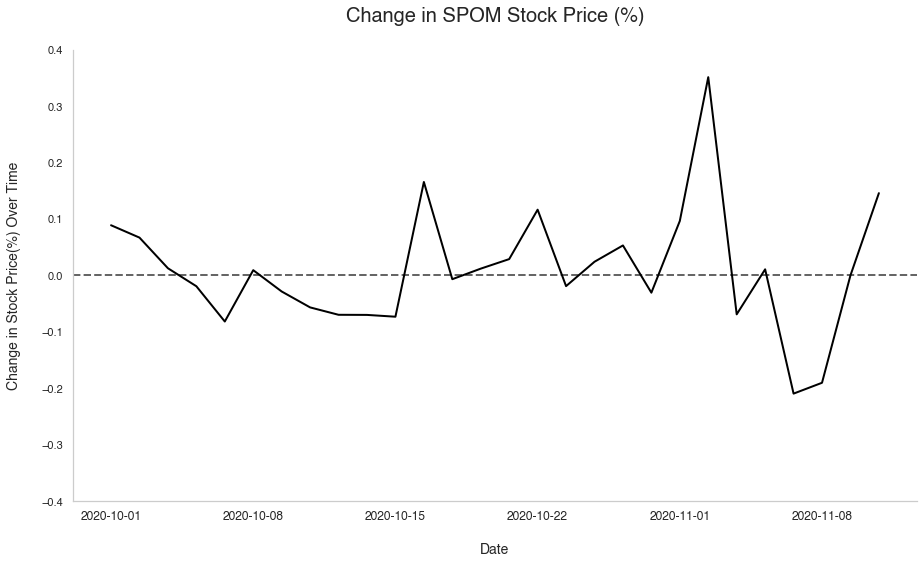

In [58]:
fig, ax = plt.subplots(figsize=(13,8))
plt.ylim(-.4,.4)

sns.lineplot(x = date_count.index, y = date_mean.stock_price_change, color='black', linewidth=2)
sns.set_theme(style='whitegrid', font='Helvetica')
ax.grid(False)

fig.tight_layout()
ax.set_title('Change in SPOM Stock Price (%)\n', fontsize=20)
ax.set_xlabel('\nDate', fontsize=14)
ax.set_xticklabels(['','2020-10-01','2020-10-08','2020-10-15','2020-10-22','2020-11-01','2020-11-08'], fontsize=12)
ax.set_ylabel('Change in Stock Price(%) Over Time\n', fontsize=14)
ax.axhline(y=0, linewidth=2, color='black', alpha=.6, linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig(f'images/SPOM_price_change');

### Visualization - $SPOM Tweet Sentiment in October and November 2020

This visualization demonstrates the change in polarity (negative vs positive tweets) over the same time period - these values are compared in the slide deck. 

In [17]:
date_count['Polarity'] = date_mean['Polarity']
date_count = date_count.reset_index()

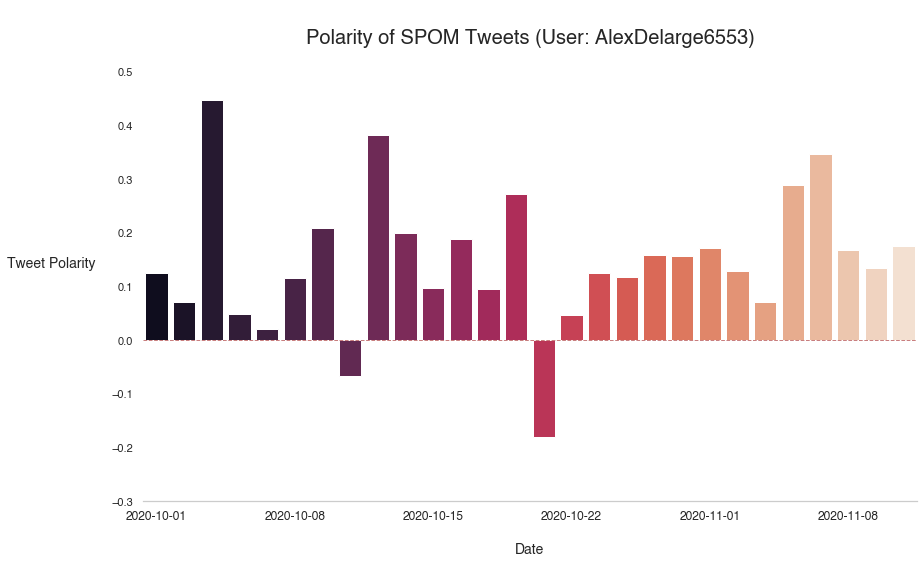

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,8))

sns.barplot(data = date_count, x = 'date_only', y = 'Polarity', palette = 'rocket')

sns.set_theme(style='whitegrid', font='Helvetica')
ax.grid(False)

plt.ylim(-.3,.5)

fig.tight_layout()
ax.set_title('\nPolarity of SPOM Tweets (User: AlexDelarge6553)\n', fontsize=20)
ax.set_xlabel('\nDate', fontsize=14)
ax.set_xticklabels(['2020-10-01','','','','','2020-10-08','','','','','2020-10-15','','','','','2020-10-22','','','','','2020-11-01','','','','','2020-11-08','',''], fontsize=12)
ax.set_ylabel('Tweet Polarity\n', fontsize=14, rotation = 0, labelpad=60)
ax.axhline(y=0, linewidth=1, color='brown', alpha=.6, linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig(f'images/Alex_SPOM_polarity')


### Visualization - $SPOM Tweet Volume in October and November 2020

This visualization demonstrates the <b>volume</b> of Tweets about SPOM in the same time period (also compared in the slide deck)

<ipython-input-39-e698144457c7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','10 ','20 ','30 ','40 ','50 ','60 '])


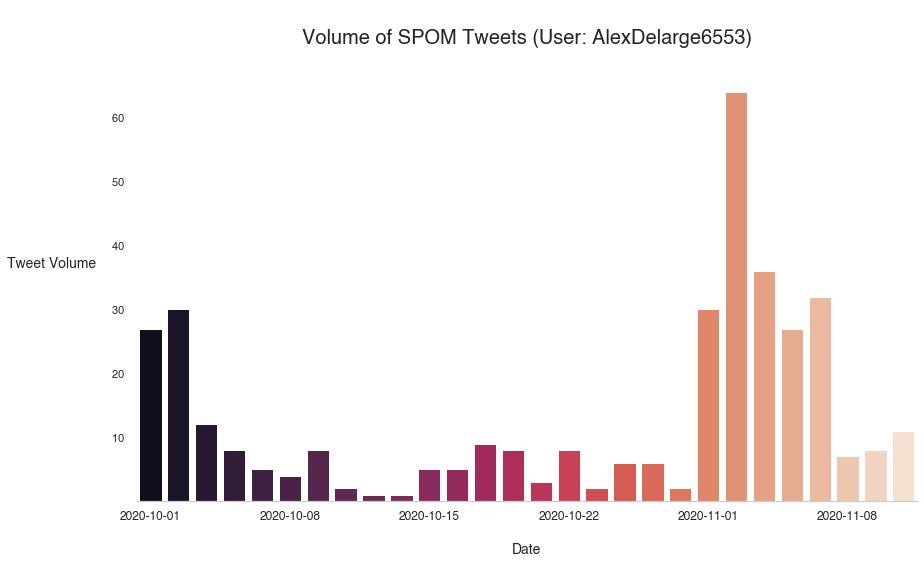

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,8))

sns.barplot(data = date_count, x = 'date_only', y = 'weekday', palette = 'rocket')

sns.set_theme(style='whitegrid', font='Helvetica')
ax.grid(False)

fig.tight_layout()
ax.set_title('\nVolume of SPOM Tweets (User: AlexDelarge6553)\n', fontsize=20)
ax.set_xlabel('\nDate', fontsize=14)
ax.set_xticklabels(['2020-10-01','','','','','2020-10-08','','','','','2020-10-15','','','','','2020-10-22','','','','','2020-11-01','','','','','2020-11-08','',''], fontsize=12)
ax.set_yticklabels(['','10 ','20 ','30 ','40 ','50 ','60 '])
ax.set_ylabel('Tweet Volume\n', fontsize=14, rotation = 0, labelpad=60)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig(f'images/Alex_SPOM_volume')


###  APPENDIX - Visualization - Popular Tweets by Username + Year

In [615]:
def popular_tweets_by_year(username,year):
    # Create filter mask to get all tweets from a certain year
    tweets_year = total_tweets[total_tweets['year'] == year]
    tweets_year.reset_index(level=0, inplace=True)
    
    # create list of most popular cashtags
    popular_year = tweets_year[tweets_year['screen_name']==username]['primary_cashtag'].value_counts().head(15)

    # create mask for all cashtags that match the list of most popular cashtags
    popular_mask = tweets_year[tweets_year['screen_name'] == username]['primary_cashtag'].isin(popular_year.index)

    # create table of all tweets with most popular cashtags
    popular_table = tweets_year[tweets_year['screen_name'] == username][popular_mask]
    popular_table.reset_index(level=0, inplace=True)
    
    # Create a table of tweets with cashtags that are the most popular BuySellShort cashtags
    cashtags_2012 = popular_table.groupby(['primary_cashtag', 'month']).count()
    cashtags_2012.reset_index(level=0, inplace=True)
    cashtags_2012.reset_index(level=0, inplace=True)
    
    # Plot cashtag usage over one year
    fig, axes = plt.subplots(sharex=True, sharey=True, figsize=(13, 8))

    sns.lineplot(x='month', y='hashtag', hue ='primary_cashtag',data=cashtags_2012)
    plt.title(f'Most Popular {username} Tweets in {year}');

In [674]:
def year_in_tweets(year):
    
    # VISUALIZE
    fig, axes = plt.subplots(3, 2, figsize=(15, 25), sharex=True)
    fig.suptitle(f'Most Popular Stock Tweets in {year}')
    
    users = ['alexcutler247', 'AlexDelarge6553', 'buysellshort', 'SimbaTrading', 'StockLizardKing', 'timothysykes']
    
    for username in users:
        # Create filter mask to get all tweets from a certain year
        tweets_year = total_tweets[total_tweets['year'] == year]
        tweets_year.reset_index(level=0, inplace=True)

        # create list of most popular cashtags
        popular_year = tweets_year[tweets_year['screen_name']==username]['primary_cashtag'].value_counts().head(15)

        # create mask for all cashtags that match the list of most popular cashtags
        popular_mask = tweets_year[tweets_year['screen_name'] == username]['primary_cashtag'].isin(popular_year.index)

        # create table of all tweets with most popular cashtags
        popular_table = tweets_year[tweets_year['screen_name'] == username][popular_mask]
        popular_table.reset_index(level=0, inplace=True)

        # Create a table of tweets with cashtags that are the most popular cashtags
        cashtags = popular_table.groupby(['primary_cashtag', 'month']).count()
        cashtags.reset_index(level=0, inplace=True)
        cashtags.reset_index(level=0, inplace=True)
    
        if username==users[0]:
            sns.lineplot(ax=axes[0,0], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[0,0].set_title(f'{username}')
        elif username==users[1]:
            sns.lineplot(ax=axes[0,1], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[0,1].set_title(f'{username}')
        elif username==users[2]:
            sns.lineplot(ax=axes[1,0], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[1,0].set_title(f'{username}')
        elif username==users[3]:
            sns.lineplot(ax=axes[1,1], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[1,1].set_title(f'{username}')
        elif username==users[4]:
            sns.lineplot(ax=axes[2,0], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[2,0].set_title(f'{username}')
        elif username==users[5]:
            sns.lineplot(ax=axes[2,1], data = cashtags, x='month', y='hashtag', hue='primary_cashtag')
            axes[2,1].set_title(f'{username}')
            
            

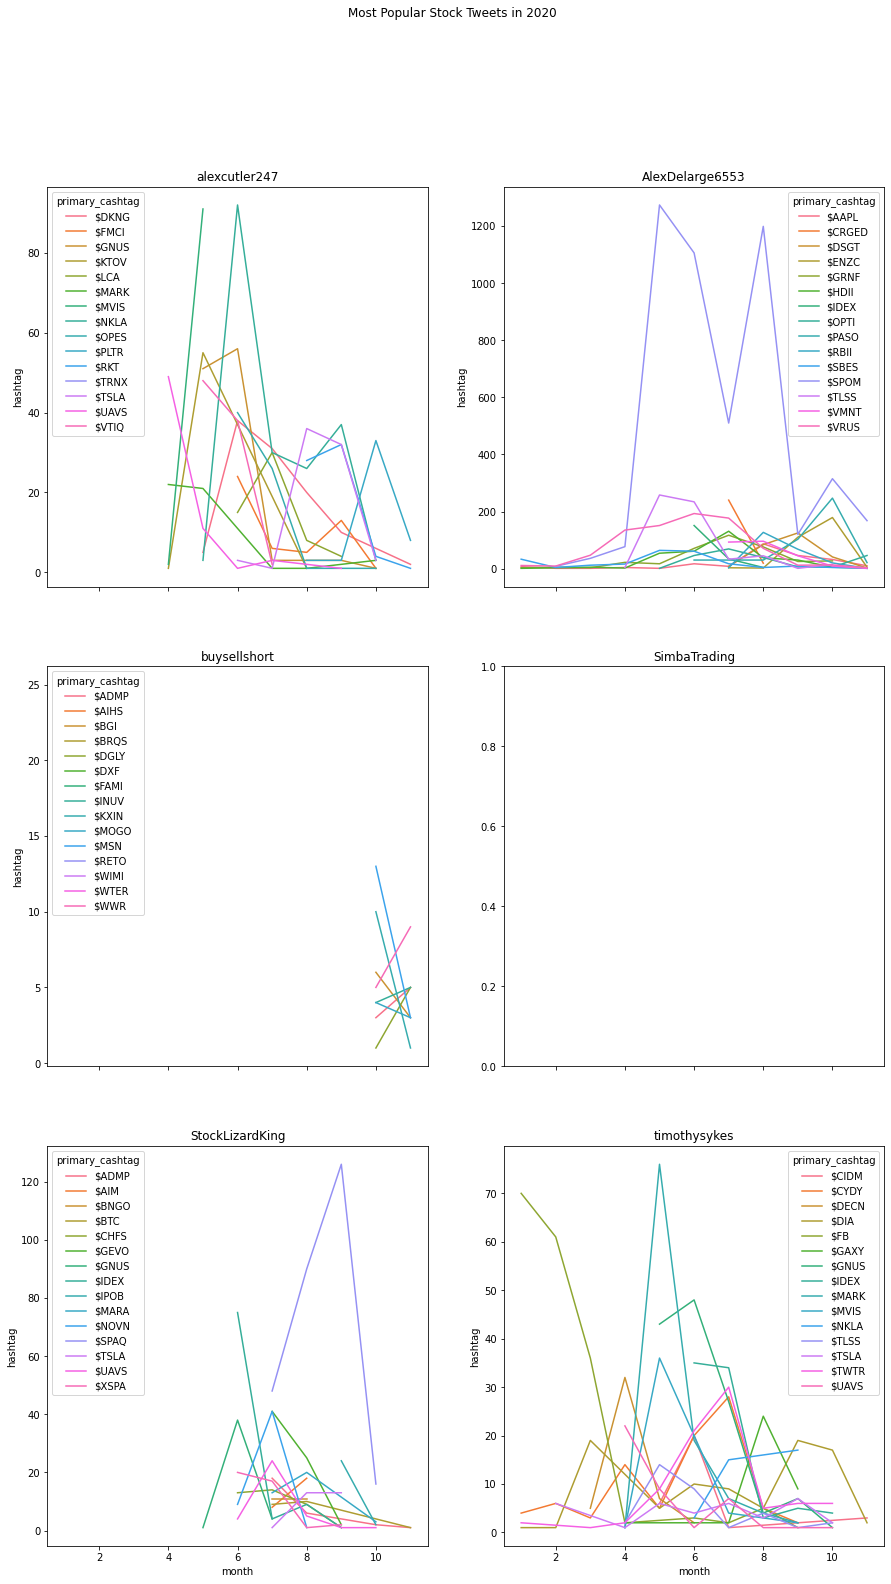

In [675]:
year_in_tweets(2020)

In [ ]:
['buysellshort','AlexDelarge6553','timothysykes','StockLizardKing', 
             'SimbaTrading','alexcutler247']

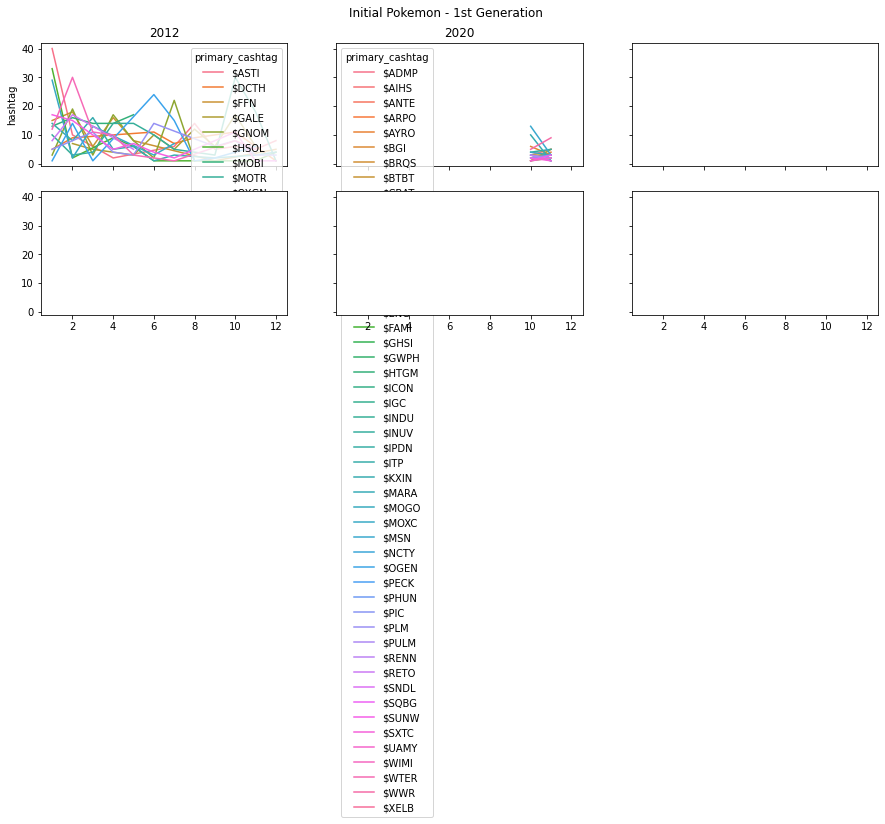

In [643]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Initial Pokemon - 1st Generation')

# Bulbasaur
sns.lineplot(ax=axes[0,0], x=cashtags_2012.month, y=cashtags_2012.hashtag, hue=cashtags_2012.primary_cashtag)
axes[0,0].set_title('2012')

# Charmander
sns.lineplot(ax=axes[0,1], x=cashtags_2020.month, y=cashtags_2020.hashtag, hue=cashtags_2020.primary_cashtag)
axes[0,1].set_title('2020');

# Squirtle
#sns.barplot(ax=axes[2], x=squirtle.index, y=squirtle.values)
#axes[2].set_title(squirtle.name)

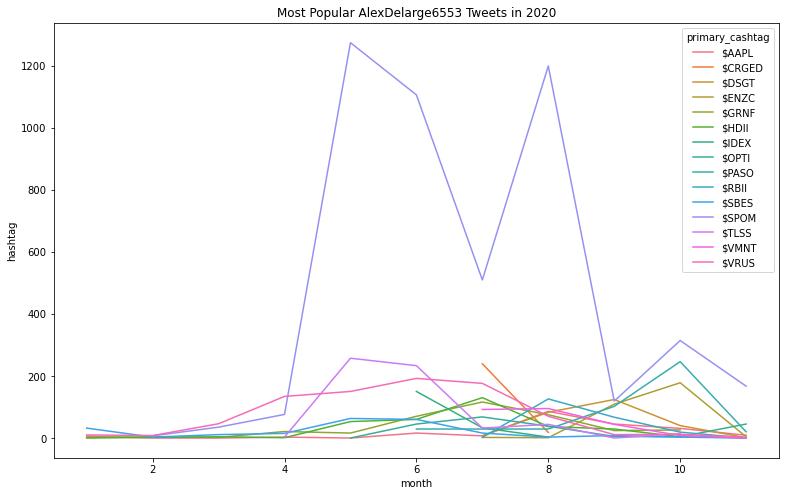

In [629]:
popular_tweets_by_year('AlexDelarge6553', 2020)